In [1]:
import plotly 
plotly.tools.set_credentials_file(username='davidsx', api_key='QaugK7BhP7fEEnqfvgHm')

In [2]:
sc

<SparkContext master=spark://ec2-52-198-32-10.ap-northeast-1.compute.amazonaws.com:7077 appName=PySparkShell>

In [3]:
sc.setLogLevel("Warn")

In [4]:
sqlContext

In [34]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
# import seaborn as sns

# from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import colorbar as cbar
from matplotlib import cbook as cbook
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf
from pyspark.sql.functions import year, month, dayofmonth, hour, minute
from pyspark.sql.types import *

import warnings
warnings.filterwarnings("ignore")

# sns.set_style("white")
# sns.set_color_codes()

In [6]:
dataSF = sc.textFile('s3a://davidsx/dataSFcrime/xaa.csv')

In [7]:
dataSF.map(lambda line: line.split(','))

PythonRDD[2] at RDD at PythonRDD.scala:53

In [8]:
customSchema = StructType([ 
    StructField("IncidntNum", StringType(), True), 
    StructField("Category", StringType(), True), 
    StructField("Description", StringType(), True), 
    StructField("DayOfWeek", StringType(), True), 
    StructField("Date_str", StringType(), True), 
    StructField("Time_str", StringType(), True), 
    StructField("District", StringType(), True), 
    StructField("Resolution", StringType(), True), 
    StructField("Address", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("PdId", StringType(), True), ])

# IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
# 150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.42158168137,37.7617007179518,"(37.7617007179518, -122.42158168137)",15006027571000

In [9]:
crimeDFsource = spark.read.csv('s3a://davidsx/dataSFcrime/', header=True, schema = customSchema)

In [10]:
from pyspark.sql.functions import to_timestamp, concat_ws

crimeDF = crimeDFsource.withColumn("DateTime_str", concat_ws(' ',crimeDFsource.Date_str,crimeDFsource.Time_str))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'MM/dd/yyyy HH:mm').cast(TimestampType()))\

crimeDF = crimeDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("Hour", hour("Datetime")).withColumn("Minute", minute("Datetime"))

crimeDF = crimeDF.drop('Date_str','Time_str','DateTime_str','Resolution','Location','PdId')
crimeDF.printSchema()

root
 |-- IncidntNum: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Datetime: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)



In [11]:
crimeDF.cache()
sqlContext.registerDataFrameAsTable(crimeDF, 'df')

In [12]:
crime_count = crimeDF.groupBy('Category')\
           .agg({'IncidntNum' : 'count'})\
           .select(col('count(IncidntNum)').alias('catCount'),col('Category'))\
           .orderBy('catCount')
# crime_count_100k_top = crime_count.where(crime_count.catCount > 100000)
# crime_count_10k_100k = crime_count.where(crime_count.catCount > 10000).where(crime_count.catCount < 100000)
# crime_count_1k_10k = crime_count.where(crime_count.catCount > 1000).where(crime_count.catCount < 10000)
# crime_count_btm_1k = crime_count.where(crime_count.catCount < 1000)
crime_count.show(40,False)

+--------+---------------------------+
|catCount|Category                   |
+--------+---------------------------+
|14      |TREA                       |
|59      |PORNOGRAPHY/OBSCENE MAT    |
|348     |GAMBLING                   |
|431     |SEX OFFENSES, NON FORCIBLE |
|741     |EXTORTION                  |
|813     |BRIBERY                    |
|925     |BAD CHECKS                 |
|1183    |FAMILY OFFENSES            |
|1292    |SUICIDE                    |
|2430    |LOITERING                  |
|2988    |EMBEZZLEMENT               |
|3931    |ARSON                      |
|4083    |LIQUOR LAWS                |
|4440    |RUNAWAY                    |
|5346    |KIDNAPPING                 |
|5672    |DRIVING UNDER THE INFLUENCE|
|8716    |RECOVERED VEHICLE          |
|9826    |DRUNKENNESS                |
|10040   |DISORDERLY CONDUCT         |
|11742   |SEX OFFENSES, FORCIBLE     |
|11891   |STOLEN PROPERTY            |
|16701   |PROSTITUTION               |
|19449   |TRESPASS       

In [ ]:
_df = crime_count.toPandas()
category_index = range(len(categories))
ind = np.arange(len(categories))

fig = plt.figure(figsize=(len(category_index),15))

# plt.bar(y_pos, performance, align='center', alpha=0.5)
ax = fig.add_subplot(111)
ax.set_xticklabels(categories)
ax.set_xticks(ind)
ax.set_ylabel('Number of Incident')
ax.set_title('Number of Incident by Category')
ax.bar(category_index,_df.catCount, color = '#00a79c')
# plt.tight_layout()
# plt.savefig('results/cat_count.png')

In [13]:
def plotCrime(df,h):
    crime_list = df.select('Category').rdd.map(lambda x: x[0]).collect()
    
    _df = df.toPandas()
    category_index = range(len(crime_list))
    ind = np.arange(len(crime_list))

    fig = plt.figure(figsize=(len(crime_list)+5,h))

    ax = fig.add_subplot(111)
    ax.set_xticklabels(crime_list)
    ax.set_xticks(ind)
    ax.set_ylabel('Number of Incident')
    ax.set_title('Number of Incident by Category')
    ax.bar(category_index,_df.catCount, color = '#00a79c')

In [26]:
gb = crimeDF.select('Hour','Category').orderBy('Category','Hour').groupBy('Hour','Category')
gbl = gb.agg({"*": "count"}).collect()
categories = crime_count.select('Category').rdd.map(lambda x: x[0]).collect()
n_categories = len(categories)
# matrix where the x-axis is the hour, and y-axis is the category
img_src = np.zeros((n_categories, 24))

In [27]:
for row in gbl :
    print(row[0]) #Hour
    print(row[1]) #Category
    print(row[2]) #count
    print(categories.index(row[1]))

0
ARSON
257
11
1
ARSON
244
11
2
ARSON
264
11
3
ARSON
262
11
4
ARSON
219
11
5
ARSON
170
11
6
ARSON
117
11
7
ARSON
89
11
8
ARSON
93
11
9
ARSON
82
11
10
ARSON
86
11
11
ARSON
83
11
12
ARSON
112
11
13
ARSON
120
11
14
ARSON
117
11
15
ARSON
140
11
16
ARSON
120
11
17
ARSON
157
11
18
ARSON
153
11
19
ARSON
165
11
20
ARSON
196
11
21
ARSON
194
11
22
ARSON
236
11
23
ARSON
255
11
0
ASSAULT
10855
35
1
ASSAULT
9256
35
2
ASSAULT
8389
35
3
ASSAULT
4283
35
4
ASSAULT
2722
35
5
ASSAULT
2188
35
6
ASSAULT
2891
35
7
ASSAULT
4289
35
8
ASSAULT
6527
35
9
ASSAULT
7210
35
10
ASSAULT
7971
35
11
ASSAULT
8482
35
12
ASSAULT
10516
35
13
ASSAULT
9120
35
14
ASSAULT
9279
35
15
ASSAULT
10399
35
16
ASSAULT
10239
35
17
ASSAULT
10452
35
18
ASSAULT
10266
35
19
ASSAULT
10039
35
20
ASSAULT
9903
35
21
ASSAULT
10273
35
22
ASSAULT
9828
35
23
ASSAULT
9317
35
0
BAD CHECKS
162
6
1
BAD CHECKS
3
6
2
BAD CHECKS
2
6
3
BAD CHECKS
3
6
4
BAD CHECKS
3
6
5
BAD CHECKS
2
6
6
BAD CHECKS
3
6
7
BAD CHECKS
12
6
8
BAD CHECKS
49
6
9
BAD CHECKS
65
6
10

1077
22
13
TRESPASS
986
22
14
TRESPASS
889
22
15
TRESPASS
967
22
16
TRESPASS
910
22
17
TRESPASS
941
22
18
TRESPASS
876
22
19
TRESPASS
789
22
20
TRESPASS
755
22
21
TRESPASS
730
22
22
TRESPASS
622
22
23
TRESPASS
547
22
0
VANDALISM
6534
32
1
VANDALISM
4562
32
2
VANDALISM
4303
32
3
VANDALISM
2898
32
4
VANDALISM
1942
32
5
VANDALISM
1611
32
6
VANDALISM
1856
32
7
VANDALISM
2518
32
8
VANDALISM
3684
32
9
VANDALISM
3474
32
10
VANDALISM
3587
32
11
VANDALISM
3395
32
12
VANDALISM
4640
32
13
VANDALISM
3600
32
14
VANDALISM
4077
32
15
VANDALISM
4801
32
16
VANDALISM
5316
32
17
VANDALISM
7077
32
18
VANDALISM
8402
32
19
VANDALISM
7619
32
20
VANDALISM
7549
32
21
VANDALISM
7683
32
22
VANDALISM
7829
32
23
VANDALISM
7102
32
0
VEHICLE THEFT
4769
34
1
VEHICLE THEFT
3255
34
None
VEHICLE THEFT
1
34
2
VEHICLE THEFT
2577
34
3
VEHICLE THEFT
1603
34
4
VEHICLE THEFT
1238
34
5
VEHICLE THEFT
1238
34
6
VEHICLE THEFT
1830
34
7
VEHICLE THEFT
3143
34
8
VEHICLE THEFT
4504
34
9
VEHICLE THEFT
4414
34
10
VEHICLE THEFT
4138
34


In [ ]:
categories.index(gbl)

In [28]:
# add the frequencies of crime per hour in the matrix
for row in gbl:
    hour = row[0]
    category = row[1]
    value = row[2]
    img_src[categories.index(category)][hour] = value

In [29]:
for row in img_src:
    m = max(row)
    for idx in range(len(row)):
        row[idx] = row[idx] / m

In [30]:
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

In [ ]:
_pd = crimeDF.where(year("Datetime") > 2016).toPandas()

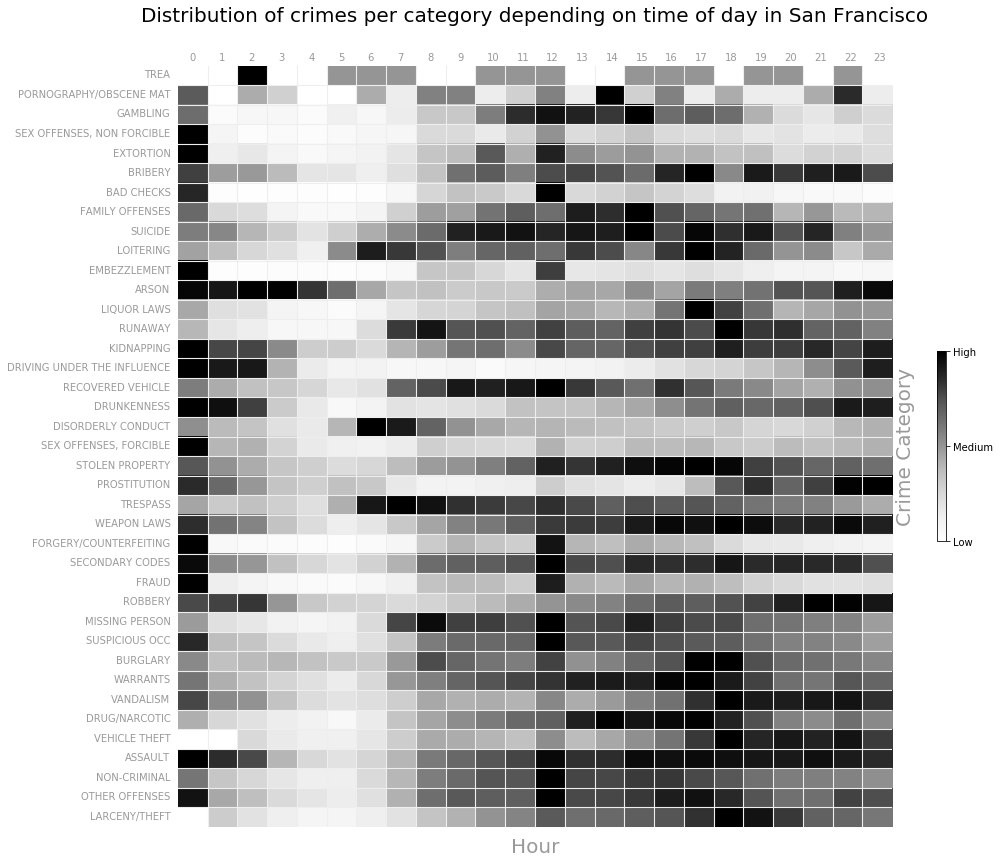

<Figure size 432x288 with 0 Axes>

In [40]:
# draw grid on axes
fig, ax = preparePlot(np.arange(.5, 23, 1), np.arange(.5, n_categories-1, 1), figsize=(16,14), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img_src, interpolation='nearest', aspect='auto', cmap=cm.Greys)

# x-axis labels
for x, y, s in zip(np.arange(-.125, 24, 1), np.repeat(-.75, 24), [str(x) for x in range(24)]):
    plt.text(x, y, s, color='#999999', size='10')
# y-axis labels
for x, y, s in zip(np.repeat(-.75, n_categories), np.arange(.125, n_categories, 1), categories):
    plt.text(x, y, s, color='#999999', size='10', horizontalalignment="right")
plt.title("Distribution of crimes per category depending on time of day in San Francisco", size=20, y=1.05)
plt.xlabel("Hour", color='#999999', size="20")
plt.ylabel("Crime Category", color='#999999', size="20")
ax.yaxis.set_label_position("right")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.25, orientation='vertical')
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])

plt.show()
plt.savefig('result/crime_distribution.png')